In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

from scipy.interpolate import interp1d

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *
from plotting_functions import *

In [15]:
speed_filter = 5 # m/s
pos_fs = 100 
f_cut = 6
box_xlen = 1 
box_ylen = 1 
binsize =  0.02
smoothing = 0.03

In [16]:
project = expipe.get_project(dl.project_path())

In [17]:
lim = [0,1200] # limit recording times - in seconds
include_actions = ['011-130321-1']
#include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
#include_actions = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, load_waveforms=True, identify_neurons=False) #if more recordings: identify_neurons=True
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions
    #tracking[action_id] = np.append(tracking[action_id], dl.load_head_direction(action_id, lim=lim)[:,:1])

print("load #spikes: ", len(spikes))

"""
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {len(spikes) / len(include_actions)}")
"""

spatial_map = sp.SpatialMap()

load #spikes:  16


In [18]:
def unit_summary(x,y,t,spike_train,**kwargs):
    fig,axs = plt.subplots(nrows=2,ncols=4,**kwargs)
    
    # ratemap
    ratemap = spatial_map.rate_map(x,y,t,spike_train)
    axs[0,0].imshow(ratemap.T,origin='lower')
    axs[0,0].set_title(f'grp={spike_train.annotations["group_id"]},unit={spike_train.annotations["unit_name"]}')
    
    # spikes and tracking
    axs[0,1] = spike_track(x,y,t,spike_train,axs[0,1],spines=False)
    axs[0,1].axis('equal')
    axs[0,1].set_title(f'#spikes={spike_train.shape[0]}')
    
    # occupancy
    occupancymap = spatial_map.occupancy_map(x,y,t)
    axs[0,2].imshow(occupancymap.T,origin='lower')
    axs[0,2].set_title('occupancy')
    
    axs[0,3].set_title(f'{spike_train.annotations["action_id"]}')
    
    mean_wfs = np.mean(spike_train.waveforms,axis=0)
    min_max = np.min(mean_wfs), np.max(mean_wfs)
    for i in range(len(mean_wfs)): #if 4 channels in every tetrode: range(4)
        axs[1,i].plot(mean_wfs[i])
        axs[1,i].set_ylim(*min_max)
        #axis_off_labels_on(axs[0,i])
    axs[1,0].set_ylabel('Mean waveform')
    
    return fig, axs

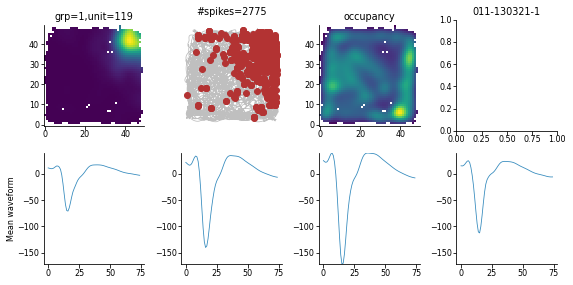

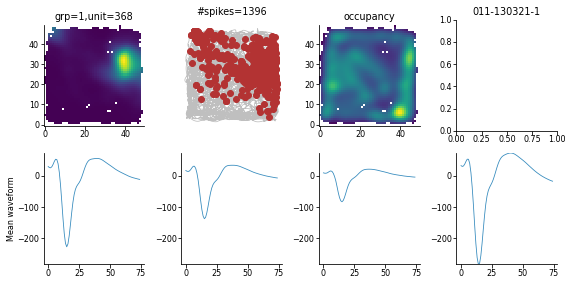

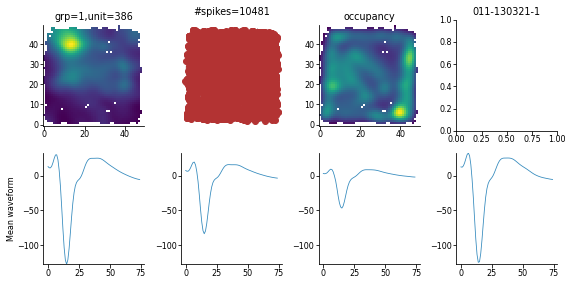

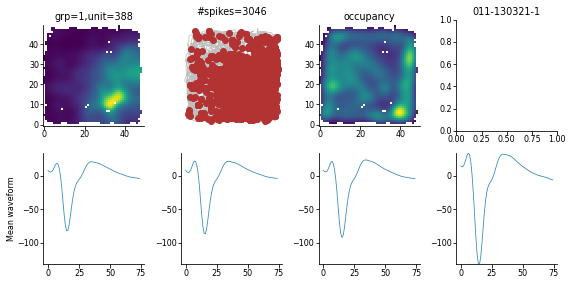

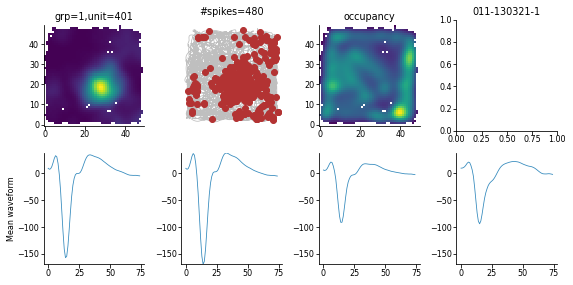

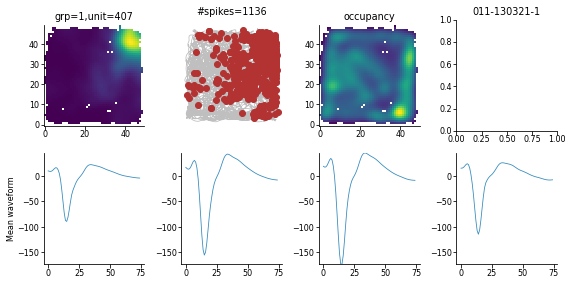

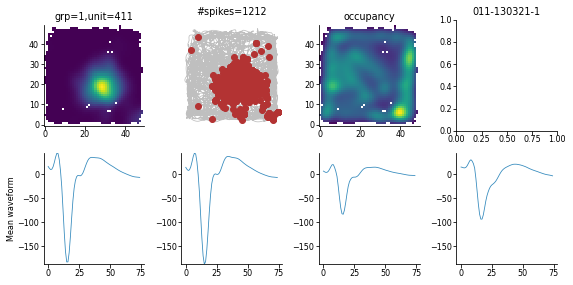

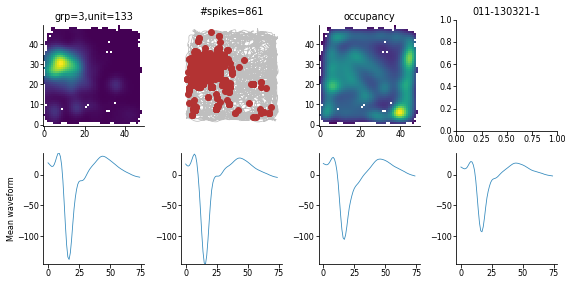

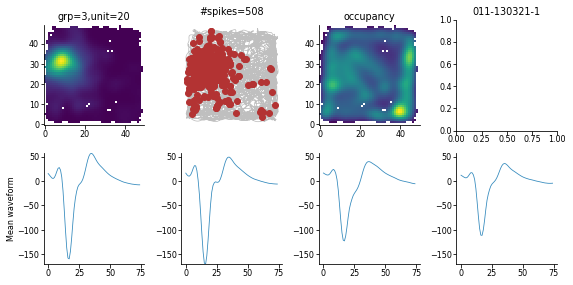

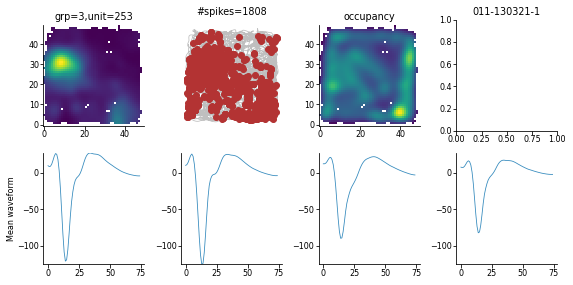

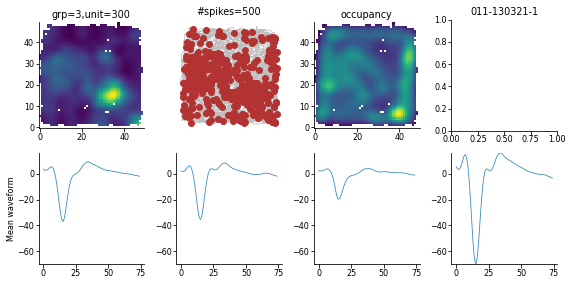

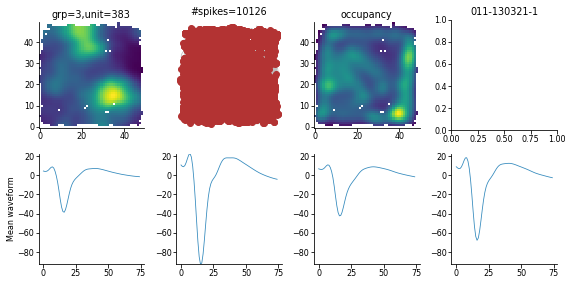

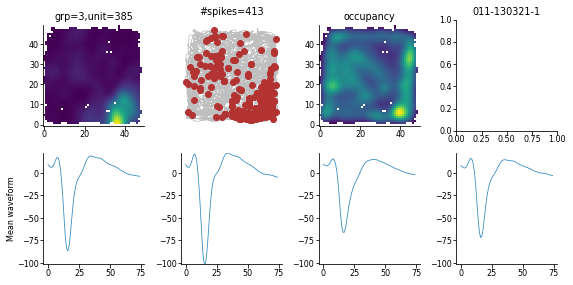

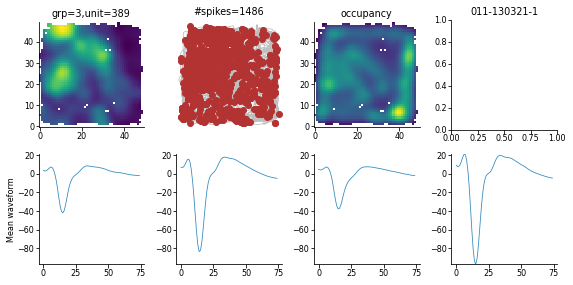

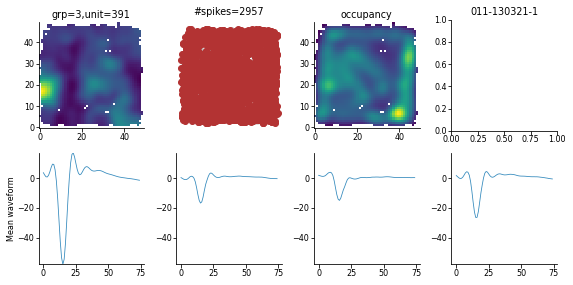

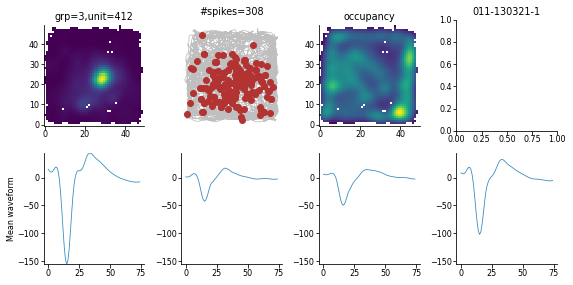

In [19]:
figsize=(8,4)

for spike_train in spikes:
    x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
    fig,axs=unit_summary(x,y,t,spike_train,figsize=figsize)